<a href="https://colab.research.google.com/github/DS-Jerry-in-Taiwan/T-bain-Category-of-Consumption-prediction/blob/main/T_bain_Category_of_Consumption_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
---
  - Load data from drive
  - Explore data analysis
  - Data pre-process
  - Build model
  - Model selection
  - reference


## Load data from google drive
---
  - Link the google colab to google drive and get the file automaticly
  - the original data is too large for google colab to run.
  Therefore, we decide to devide data into two parts： **member.csv** and **comsumption_channel.csv**. 
  
  - The data we use here is from **member.csv**, and columns show following：
  dt/chid/shop_tag/txn_cnt/txn_amt/masts/educd/trdtp/naty/poscd/cuorg/slam/gender_code/age/primary_card
  - [column explanaion](https://docs.google.com/document/d/1B8rPY2swEDeTGVJhIWmqkFH8xQ3W-WZ3/edit)
 

In [ ]:
# data = pd.read_csv(file_dict['csv'][0],usecols=['dt', 'chid', 'shop_tag', 'txn_cnt','txn_amt','masts', 'educd', 'trdtp', 'naty', 'poscd', 'cuorg', 'slam','gender_code', 'age', 'primary_card'])#about the upper bound of nrow

# data.to_csv("member.csv")


In [ ]:
#Import modules
# !pip install py7zr
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from google.colab import drive
import csv
from pandas.core.common import random_state
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler,StandardScaler

### [how get  the data from shared drive](https://stackoverflow.com/questions/54351852/accessing-shared-with-me-with-colab)
- use the short-cust way
- use the dowload way

In [ ]:
#Way 1 ：set up your working directory and read file directly(read the file on your own drive)
def link_to_dir(path):
  drive.mount('/content/gdrive')
  main_path = path
  os.chdir(path)
link_to_dir("/content/gdrive/MyDrive/adventure_time/T_brain")
data = pd.read_csv("member.csv")
data.info(verbose=False,memory_usage="deep")

Mounted at /content/gdrive
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32975653 entries, 0 to 32975652
Columns: 16 entries, Unnamed: 0 to primary_card
dtypes: float64(10), int64(5), object(1)
memory usage: 5.5 GB


In [ ]:
#Way 2：Create a drive client and get the file by shared link id(get the file to google colab space,and read it afterward)
def link_to_file(id,file_name):
  #Authenticate and create the PyDrive client
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)


  # 2-1. Get the Shareable link
  """
  full data link : https://drive.google.com/file/d/1-991t_LoEhJVAh5ICYMZatOKFKw0z9NF/view?usp=sharing
  member data link ：https://drive.google.com/file/d/1-3rfmZbv3j37Tt_gDvsc0lbaKSJjVcME/view?usp=sharing
  """

  # 2-2. Get the id from the link id(1-991t_LoEhJVAh5ICYMZatOKFKw0z9NF、1-3rfmZbv3j37Tt_gDvsc0lbaKSJjVcME)

  # download the file
  # downloaded_full_data = drive.CreateFile({'id':"1-991t_LoEhJVAh5ICYMZatOKFKw0z9NF"})   
  # downloaded_full_data.GetContentFile('tbrain_cc_training_48tags_hash_final.csv')       

  downloaded_member_data = drive.CreateFile({'id':id})   
  downloaded_member_data.GetContentFile(file_name) 

#Read data
#data = pd.read_csv("member.csv")

In [ ]:
# Save complete customer data before we filter data by shop_tag
cust_info = data[['dt','chid','masts','educd','trdtp','naty', 'poscd','cuorg', 'slam','gender_code','age','primary_card']]

#For save memory, just keep shop_tag we need
data = data.loc[data.shop_tag.isin(['2','6',"10","12","13","15","18","19","21","22","25","26","36","37","39","48"])]
data.drop('Unnamed: 0',axis=1,inplace=True)
#Just View the data
cust_info.head()

,dt,chid,masts,educd,trdtp,naty,poscd,cuorg,slam,gender_code,age,primary_card
0,1,10321418,1.0,4.0,5.0,1.0,99.0,30.0,95982.822967,1.0,4.0,1
1,1,10414574,2.0,2.0,15.0,1.0,2.0,30.0,130702.351368,1.0,3.0,1
2,1,10134567,1.0,3.0,11.0,1.0,3.0,30.0,112010.611717,0.0,4.0,1
3,1,10001003,2.0,3.0,11.0,1.0,2.0,30.0,59701.507360,0.0,3.0,1
4,1,10267183,2.0,6.0,15.0,1.0,99.0,30.0,NaN,0.0,6.0,0


In [ ]:
len(data['chid'].unique())

498040

In [ ]:
#To check the duplicated data of each column, such as masts,educd,trdtp,poscd,cuorg,slam
# info_count = cust_info.groupby(['chid']).nunique().reset_index()
# for i in info_count.columns[5:]:
#   if any(info_count[i] > 1):
#     print(i)

#After checking a few columns, decide to uniformly use recent data for each customer
cust_info = cust_info.sort_values(by=['dt','chid'])
cust_info.drop_duplicates(['chid'],keep='last',inplace=True)
cust_info_id = cust_info[['chid']].reset_index(drop=True)
cust_info_id.head()

,chid
0,10000348
1,10000458
2,10003976
3,10004790
4,10007159


## Explore data analysis


### reference
---
  - [introduction of seaborn](https://seaborn.pydata.org/introduction.html?highlight=gradient%20palette)
  - [pairplot](https://seaborn.pydata.org/generated/seaborn.pairplot.html)
  - [heatmap](https://seaborn.pydata.org/generated/seaborn.heatmap.html?highlight=heatmap#seaborn.heatmap)
    - [heatmap example](https://medium.com/@szabo.bibor/how-to-create-a-seaborn-correlation-heatmap-in-python-834c0686b88e)
    - [annotation adjust](https://stackoverflow.com/questions/54506626/how-to-understand-seaborns-heatmap-annotation-format)
  - [histgram - for frequency of continue var](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html)
  - [barplot - for frequency of cataegory var](https://seaborn.pydata.org/generated/seaborn.barplot.html)
    - [Different between hist and barplot1](https://www.brighthubpm.com/six-sigma/58254-box-plots-vs-histograms-in-project-management/)
    - [Different between hist and barplot2](https://citoolkit.com/articles/histograms-and-boxplots/)
  - [countplot](https://seaborn.pydata.org/generated/seaborn.countplot.html?highlight=countplot#seaborn.countplot)
    - [multiple counplot](https://www.youtube.com/watch?v=4DnWYK88-E4&ab_channel=SessionWithSumit)


Customer number： 498040


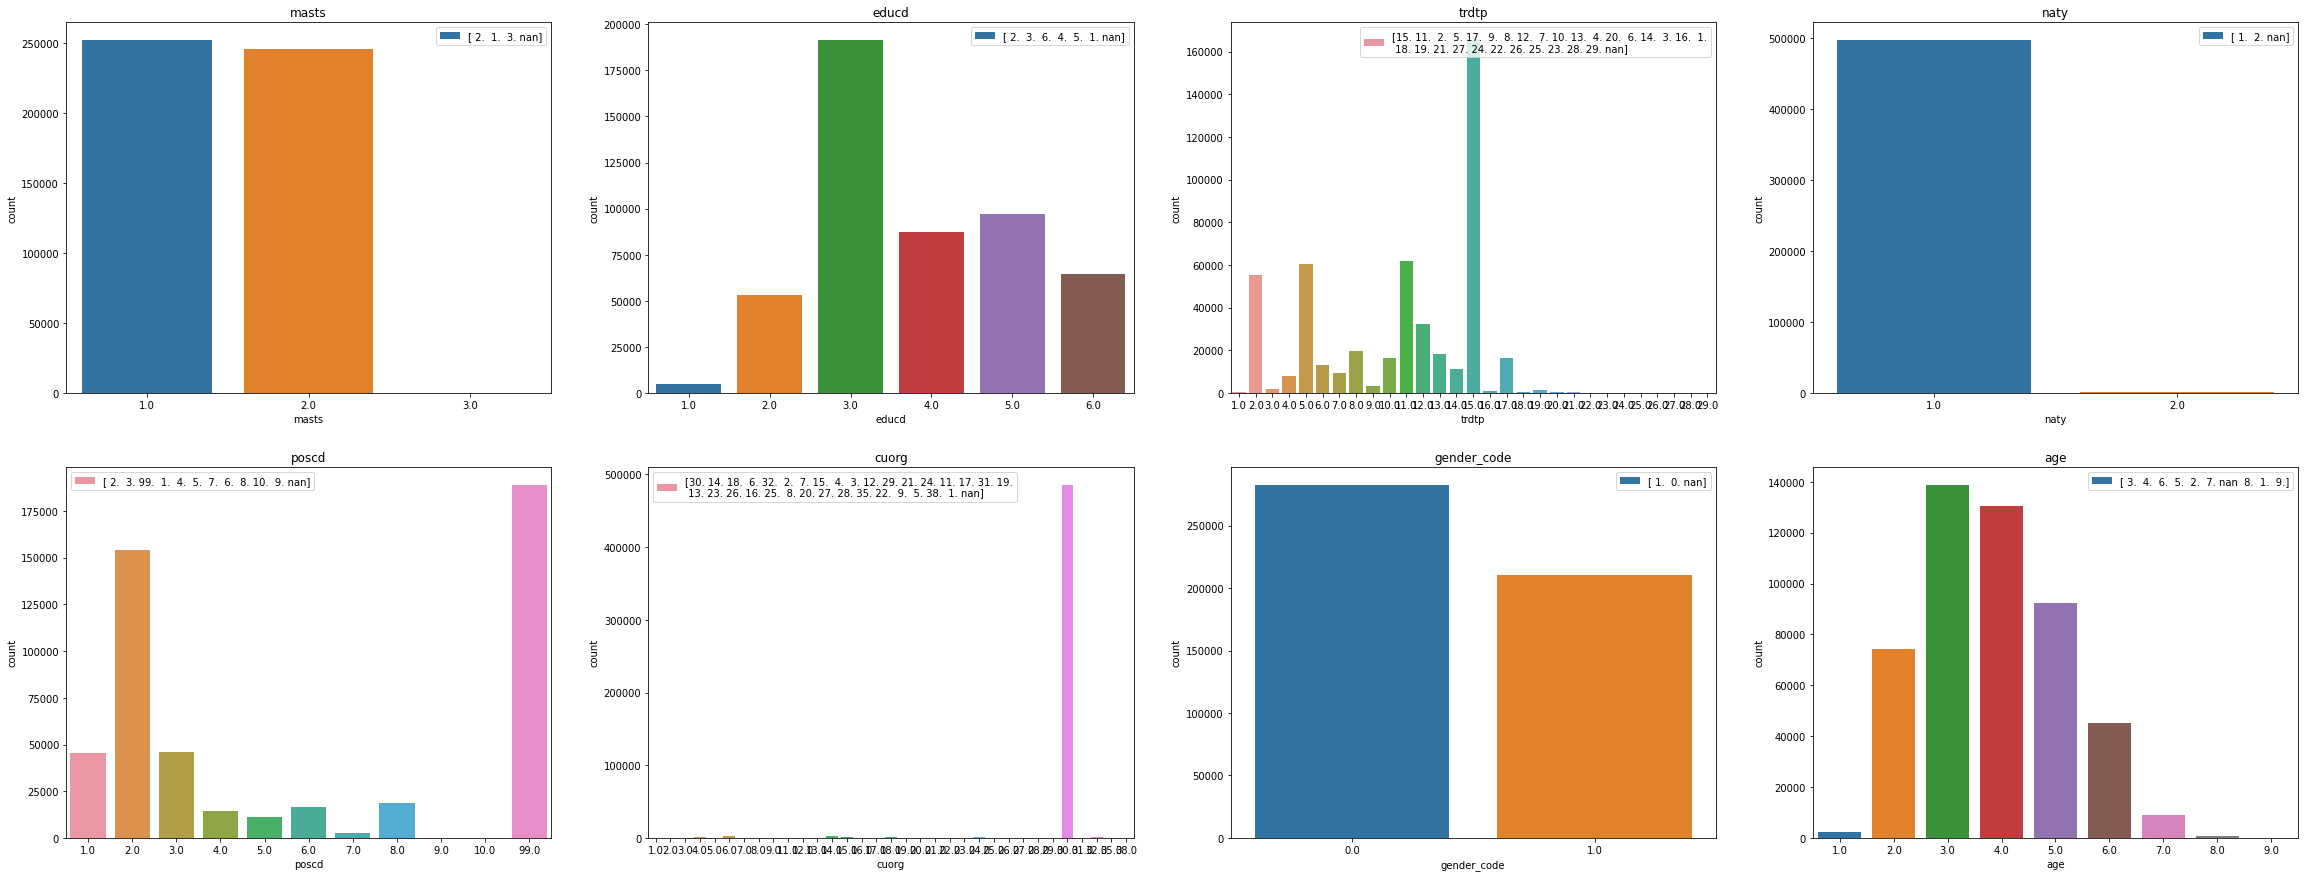

In [ ]:
# customer information analysis 
data_grp = data[['chid','masts', 'educd', 'trdtp', 'naty', 'poscd', 'cuorg','gender_code', 'age']].drop_duplicates(['chid'])

print("Customer number：",data_grp.shape[0]) #the total customer number is about 498040
def cate_count(df,cust_id,cate):
  return pd.DataFrame(df[[cust_id,cate]].groupby([cate]).count())

info_dict = dict()

# check number customer in the each category
for i in ['masts', 'educd', 'trdtp', 'naty', 'poscd', 'cuorg','gender_code', 'age']:
  info_dict[i] = cate_count(data_grp,"chid",i)

#Suppress warnign message while print plot
import warnings
warnings.filterwarnings('ignore')

plt.figure(figsize = (40,15))
col_idx = list(enumerate(['masts', 'educd', 'trdtp', 'naty', 'poscd', 'cuorg','gender_code', 'age']))
for idx,val in col_idx:
  plt.subplot(2,4,idx+1)
  plt.title(val)
  sns.countplot(val,data=data_grp)
  # plt.legend(labels=[data_grp[val].unique()])
  


#From the result, we got a big picture of distribution of each category columns
#Take a quick notes：
# masts：almost 1 and 2
# educat: 3 is the most
# gender_code：0 is little higher than 1
# age：most customer are around 4-5



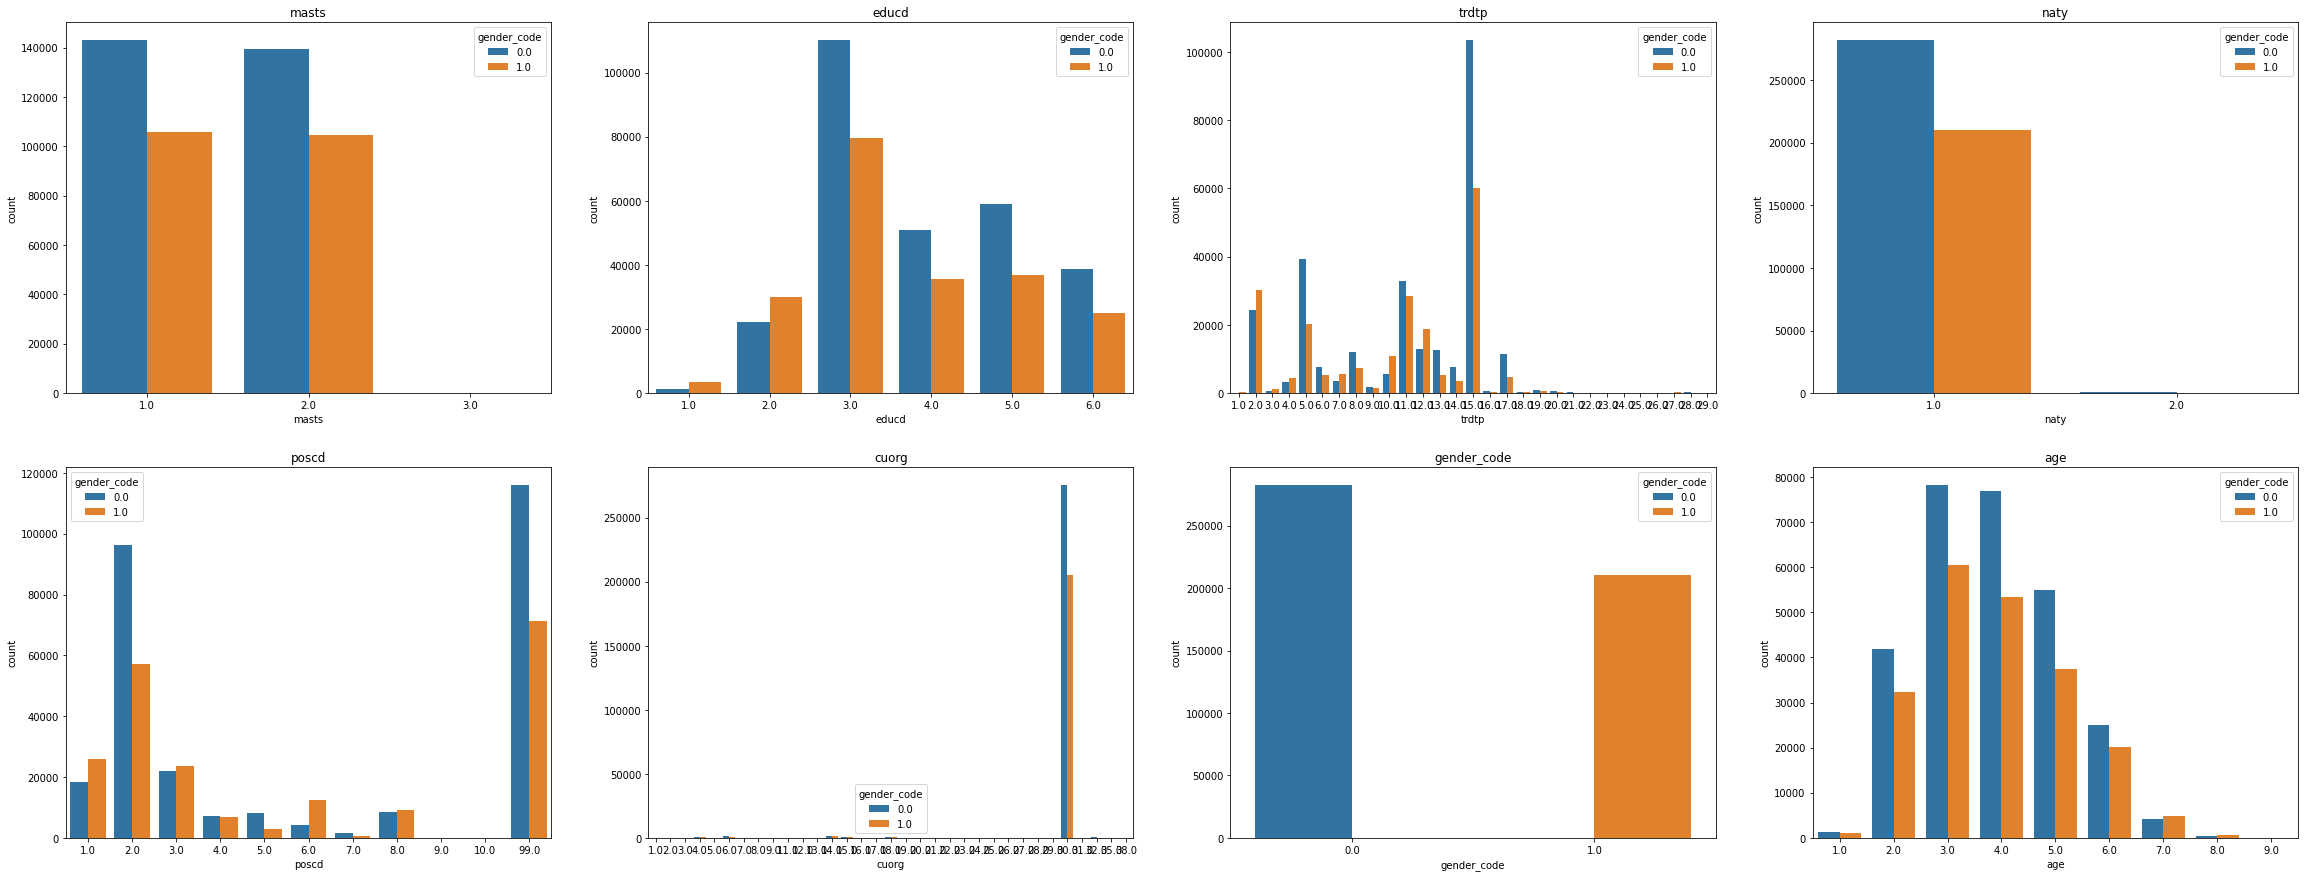

In [ ]:
#Countplot by gender
plt.figure(figsize = (40,15))
for idx,val in col_idx:
  plt.subplot(2,4,idx+1)
  plt.title(val)
  sns.countplot(val,data=data_grp,hue='gender_code')
#Take a quick notes：
# It almost loook the same as picture without (hue='gender)
# number of customer may have no big different between gender

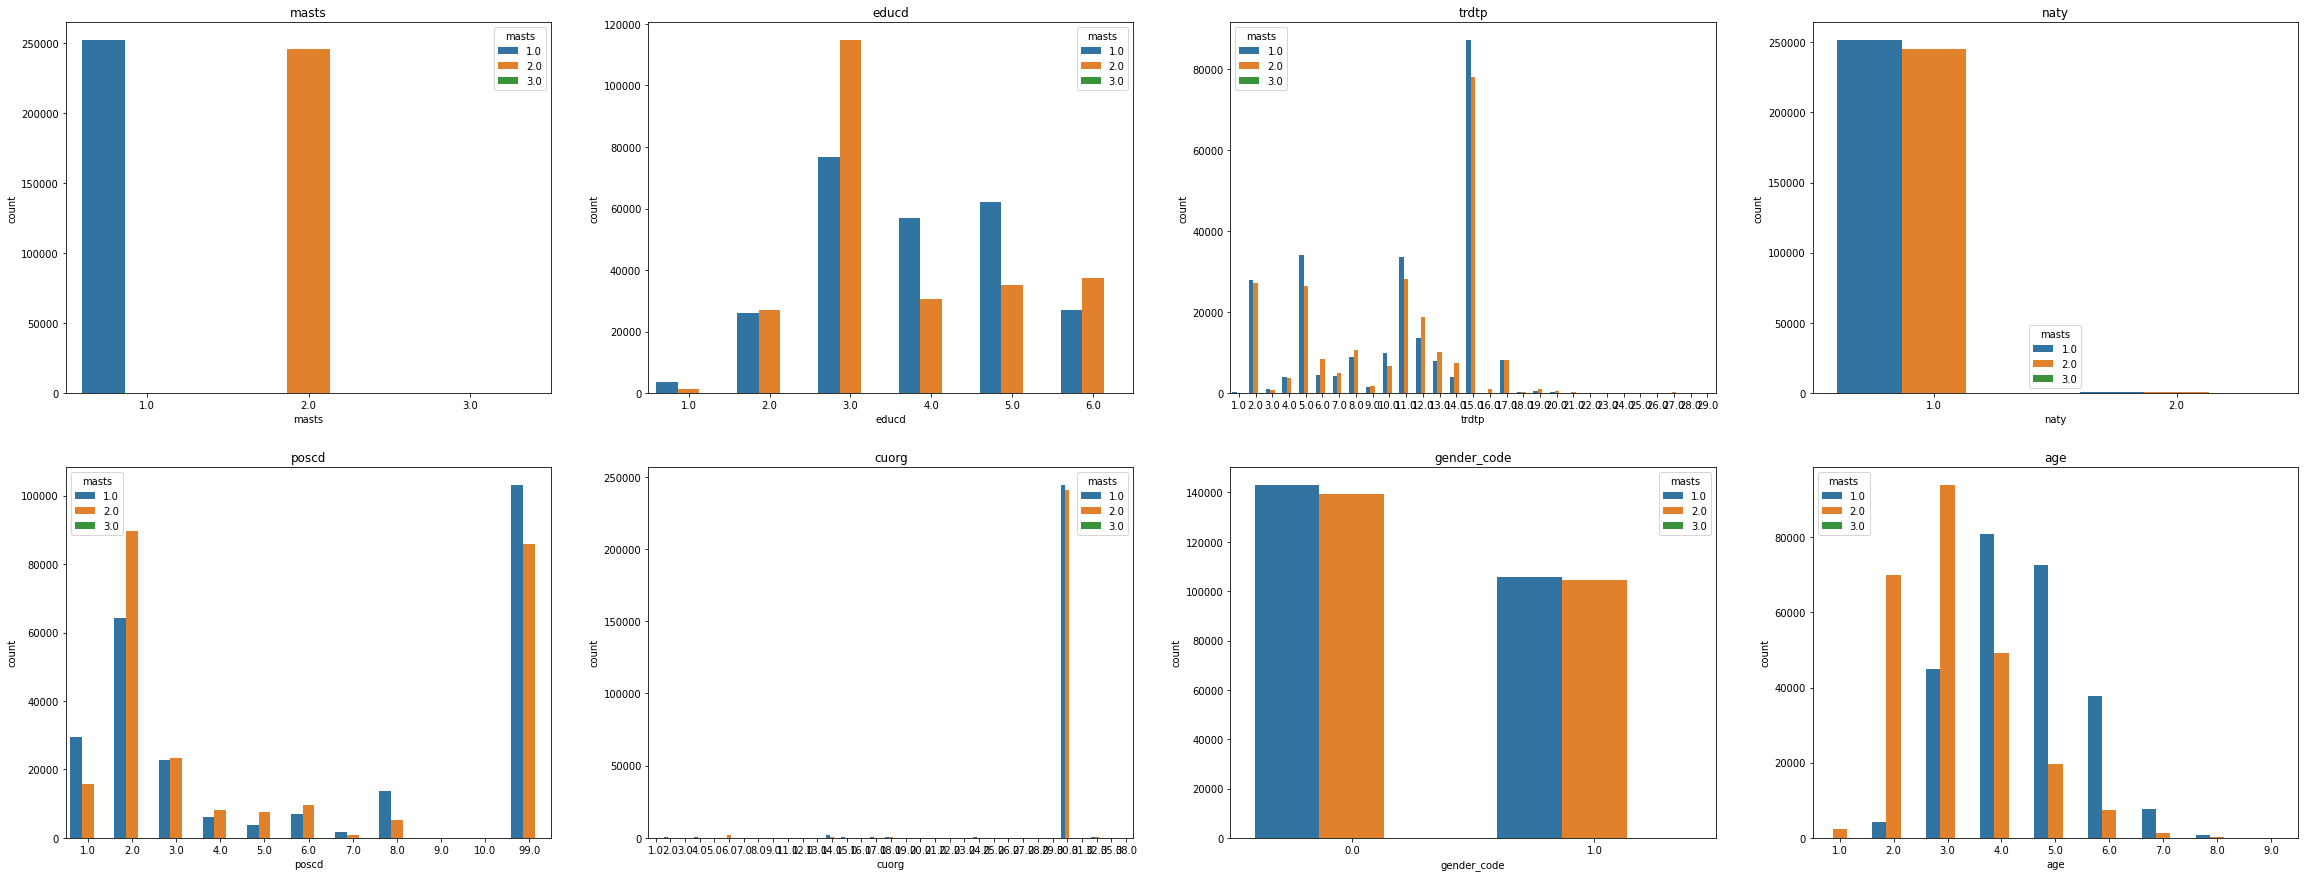

In [ ]:
#Countplot by type of marital status
plt.figure(figsize = (40,15))
for idx,val in col_idx:
  plt.subplot(2,4,idx+1)
  plt.title(val)
  sns.countplot(val,data=data_grp,hue='masts')
#Take a quick notes：
# distribution of age is little different between marital status 

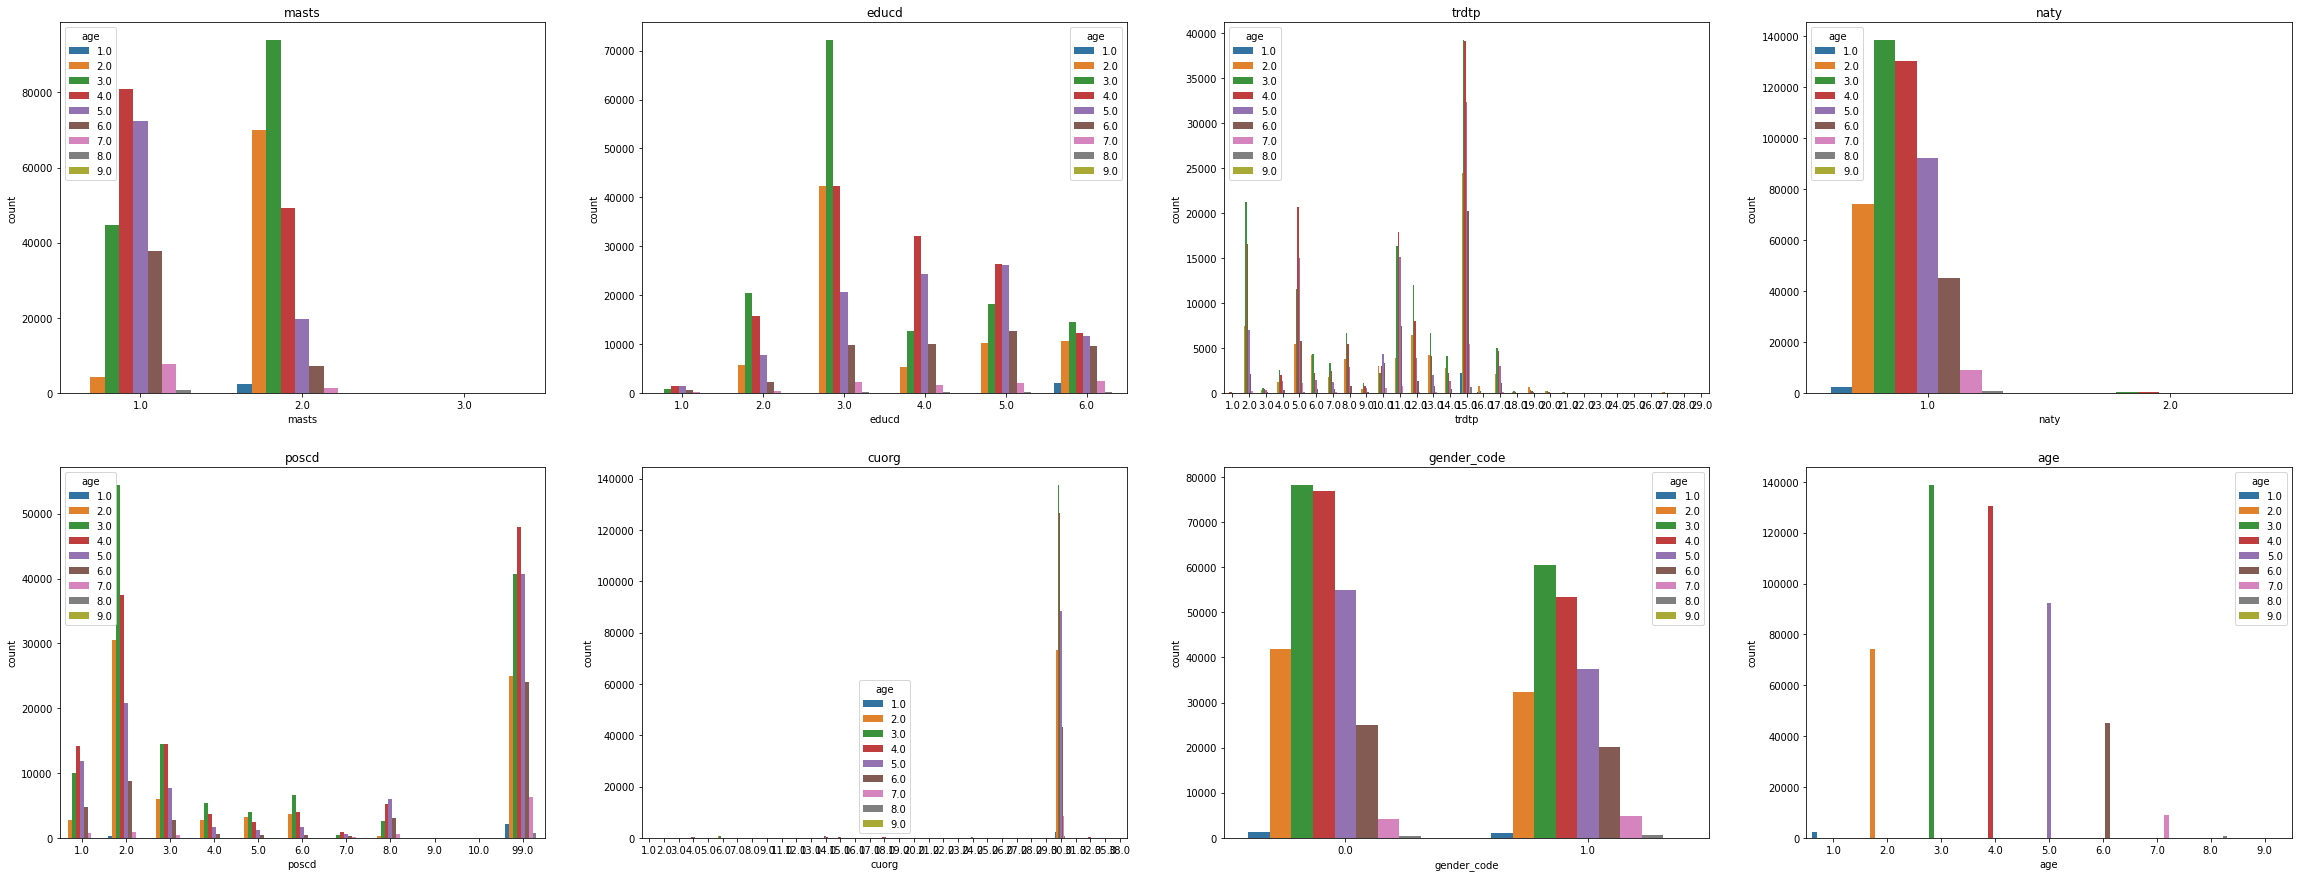

In [ ]:
#Countplot by type of age
plt.figure(figsize = (40,15))
for idx,val in col_idx:
  plt.subplot(2,4,idx+1)
  plt.title(val)
  sns.countplot(val,data=data_grp,hue='age')
#Take a quick notes：
# 

Text(0.5, 1.0, 'na_num of each column')

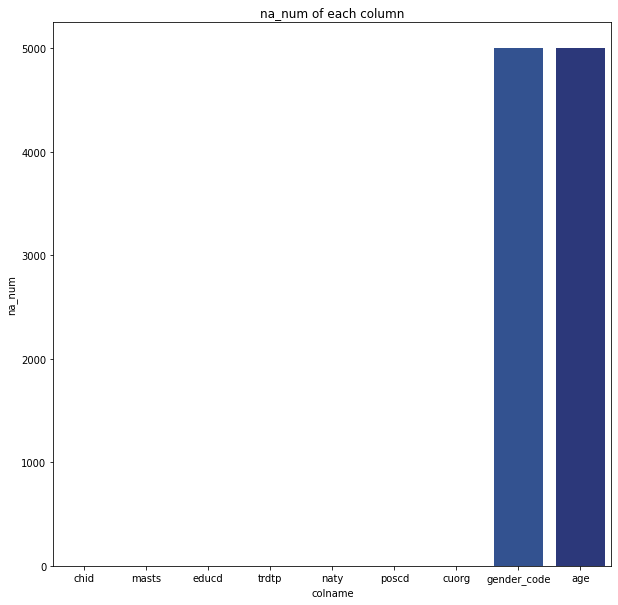

In [ ]:
# NA number check
na_check = data_grp.isnull().sum().reset_index()
na_check.columns = ['colname','na_num']
fig,ax = plt.subplots(figsize = (10,10))
sns.barplot(x=na_check['colname'],y=na_check['na_num'],ax = ax,palette='YlGnBu')
ax.set_title("na_num of each column")

#Take a quick notes：
# missing values are almost in two columns 

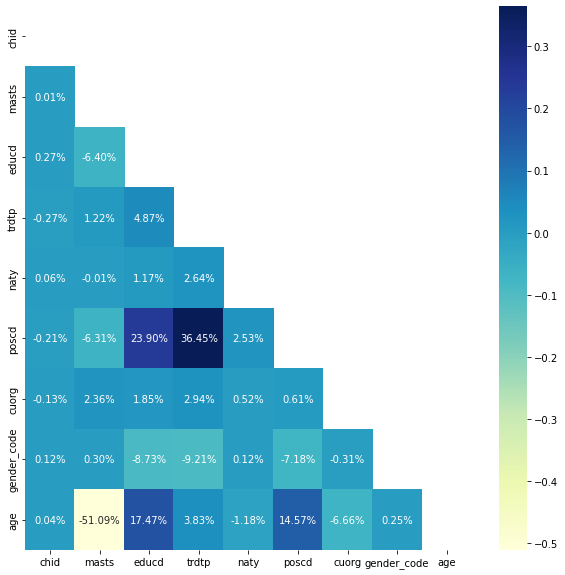

In [ ]:
#Bulid a correlatopm matrix and visualize by heatmap
corr_matrix = data_grp.corr()

#create a mask to plot only part of heatmap
mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True

fig,ax = plt.subplots(figsize=(10,10))
sns.heatmap(corr_matrix,annot = True,ax=ax,cmap='YlGnBu',mask=mask,fmt=".2%")
#Take a quick notes：
# more relative relative columns：
# 1. poscd/masts, poscd/educd, poscd/trdtp
# 2. gender_code/masts, gender_code/trdtp, gender_code/poscd
# 3. age/masts, age/educd, age/poscd, age/curog
# 4. 

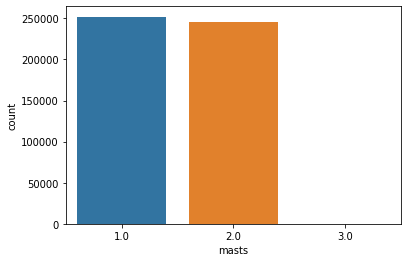

In [ ]:
# np.histogram(info_dict[0])
sns.countplot(x='masts',data=data_grp)

In [ ]:
mask = np.zeros_like(corr_matrix)

In [ ]:
sns.pairplot(data_grp)

###How  much money each customer spending on each commodity in average

In [ ]:

shopping_data = data[['chid','shop_tag','txn_amt','txn_cnt']]
shopping_data = shopping_data.pivot_table(index = 'chid',
                      columns = 'shop_tag',
                      values = ['txn_amt','txn_cnt'],
                      aggfunc='mean',fill_value = 0).reset_index()


shopping_data.columns = [c1+c2 for c1,c2 in shopping_data.columns]


standardscaler = StandardScaler()
cust_info.slam = standardscaler.fit_transform(cust_info[['slam']])
display(shopping_data.head())


In [ ]:
standardscaler = StandardScaler()
amt_cnt_col = list(shopping_data.drop(['chid'],axis=1).columns)
shopping_data[amt_cnt_col] = standardscaler.fit_transform(shopping_data.drop(['chid'],axis=1).values)

In [ ]:
shopping_data_inthreemonth = data[data.dt > 21][['chid','shop_tag','txn_amt','txn_cnt']]
shopping_data_inthreemonth = shopping_data_inthreemonth.pivot_table(index = 'chid',
                                   columns = 'shop_tag',
                                   values = ['txn_amt','txn_cnt'],
                                   aggfunc='mean',fill_value = 0).reset_index()

shopping_data_inthreemonth.columns = [c1+c2 for c1,c2 in shopping_data_inthreemonth.columns]
display(shopping_data_inthreemonth.head())
display(shopping_data_inthreemonth.columns)

,chid,txn_amt10,txn_amt12,txn_amt13,txn_amt15,txn_amt18,txn_amt19,txn_amt2,txn_amt21,txn_amt22,txn_amt25,txn_amt26,txn_amt36,txn_amt37,txn_amt39,txn_amt48,txn_amt6,txn_cnt10,txn_cnt12,txn_cnt13,txn_cnt15,txn_cnt18,txn_cnt19,txn_cnt2,txn_cnt21,txn_cnt22,txn_cnt25,txn_cnt26,txn_cnt36,txn_cnt37,txn_cnt39,txn_cnt48,txn_cnt6
0,10000000,10315.900321,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,9156.086033,0.0,2.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,10000001,12847.384866,6298.419357,0.0,0.000000,0.0,0.0,0.0,10223.421432,3945.661088,0.0,0.0,0.000000,4435.600493,0.0,8326.695004,0.0,1.000000,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.5,0.0
2,10000002,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,3571.095195,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,10000005,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,6221.656309,10062.523765,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,7.0,0.0,0.0,0.0
4,10000006,0.000000,0.000000,0.0,9965.795214,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Index(['chid', 'txn_amt10', 'txn_amt12', 'txn_amt13', 'txn_amt15', 'txn_amt18',
       'txn_amt19', 'txn_amt2', 'txn_amt21', 'txn_amt22', 'txn_amt25',
       'txn_amt26', 'txn_amt36', 'txn_amt37', 'txn_amt39', 'txn_amt48',
       'txn_amt6', 'txn_cnt10', 'txn_cnt12', 'txn_cnt13', 'txn_cnt15',
       'txn_cnt18', 'txn_cnt19', 'txn_cnt2', 'txn_cnt21', 'txn_cnt22',
       'txn_cnt25', 'txn_cnt26', 'txn_cnt36', 'txn_cnt37', 'txn_cnt39',
       'txn_cnt48', 'txn_cnt6'],
      dtype='object')

In [ ]:
#How is the distribution of na value
#From result, most of na value are in the slam, age and gender columns
#For some privacy reasons, customer are not willing to declare too information about themselves.
EDA_na = data.isnull().sum().reset_index()
EDA_na.columns = ['cols','num']
EDA_na['ratio'] = (EDA_na.num / data.shape[0])*100
EDA_na

In [ ]:
EDA_na = cust_info.isnull().sum().reset_index()
EDA_na.columns = ['cols','num']
EDA_na['ratio'] = (EDA_na.num / cust_info.shape[0])*100
EDA_na

## Data pre-process：
---

### reference
  - [Imputer example](https://scikit-learn.org/stable/auto_examples/impute/plot_iterative_imputer_variants_comparison.html#sphx-glr-auto-examples-impute-plot-iterative-imputer-variants-comparison-py)
  - [Simple](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html#sklearn.impute.SimpleImputer)
  - [iterative](https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html#sklearn.impute.IterativeImputer)

### Impute NA value with Sickitlearn：
  - First, impute the Slam column with simple imputer.
  - Then, try different iterative imputer for other column containing NA


In [ ]:
cust_info.drop(['chid','dt'],axis=1,inplace=True)


In [ ]:
from sklearn.impute import SimpleImputer
simple_imputer = SimpleImputer(missing_values = np.nan, strategy = 'median')
slam = simple_imputer.fit_transform(cust_info[['slam']])
cust_info.slam = slam
# display(pd.DataFrame(slam).head())
display(cust_info.head())

,masts,educd,trdtp,naty,poscd,cuorg,slam,gender_code,age,primary_card
14554439,2.0,2.0,12.0,1.0,3.0,30.0,76875.484753,1.0,4.0,0
15190636,2.0,3.0,15.0,1.0,99.0,30.0,42617.531543,0.0,3.0,1
15010619,1.0,5.0,15.0,1.0,99.0,30.0,56894.810946,0.0,4.0,1
15202669,2.0,4.0,15.0,1.0,3.0,30.0,99444.517732,1.0,4.0,1
14871602,2.0,3.0,5.0,1.0,2.0,30.0,71382.709400,1.0,3.0,1


In [ ]:
# Try to use different imputer

# baysian_imputer = IterativeImputer(random_state=0,sample_posterior=True)
# cust_info1 = baysian_imputer.fit_transform(cust_info)

# simple_impuiter = SimpleImputer(missing_values=np.nan,strategy='most_frequent')

# cust_info1 = simple_impuiter.fit_transform(cust_info)

# decisiontree_imputer = IterativeImputer(random_state=0,estimator=DecisionTreeRegressor(max_features="sqrt", random_state=0))

# cust_info2 = decisiontree_imputer.fit_transform(cust_info)

# knn_imputer = IterativeImputer(random_state=0,estimator= KNeighborsRegressor(n_neighbors=15))
# cust_info3 = knn_imputer.fit_transform(cust_info)


extradecisiontree_imputer = IterativeImputer(random_state=0,estimator=ExtraTreesRegressor(n_estimators=10, random_state=0))

cust_info3 = extradecisiontree_imputer.fit_transform(cust_info)

/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:701: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  ConvergenceWarning,


### Normalize the numeric column：

  - Slam is too large for float32 type during model training.
  Therefore, it need to be scaling to prevent model from crashing.
  In order to keep value bigger than 0, choose min-max scaler in this project.

In [ ]:
#Preprocessing：normalize slam column
norm = MinMaxScaler()
cust_info.slam = norm.fit_transform(cust_info[['slam']])
# stand = StandardScaler()
# display(stand.fit_transform(cust_info[['slam']])[0:1,0:1])
cust_info.head()


,masts,educd,trdtp,naty,poscd,cuorg,slam,gender_code,age,primary_card
14554439,2.0,2.0,12.0,1.0,3.0,30.0,1.119390e-106,1.0,4.0,0
15190636,2.0,3.0,15.0,1.0,99.0,30.0,5.624560e-107,0.0,3.0,1
15010619,1.0,5.0,15.0,1.0,99.0,30.0,7.945627e-107,0.0,4.0,1
15202669,2.0,4.0,15.0,1.0,3.0,30.0,1.486296e-106,1.0,4.0,1
14871602,2.0,3.0,5.0,1.0,2.0,30.0,1.030094e-106,1.0,3.0,1


### Concate dataframe together ：customer information and shopping records
---
  - In order to have full infomation of all customer after pre-process, we combine two dataframe into one

In [ ]:
#concat attempts to merge/align by index 
#So use reset_index to set the index to default
cust_info3_df = pd.DataFrame(cust_info3).reset_index(drop=True)
cust_info3_df.columns = list(cust_info.columns)


new_columns = list(cust_info_id.columns)
new_columns.extend(list(cust_info3_df.columns))
cust_info3_df=pd.concat([cust_info_id,cust_info3_df],axis = 1,ignore_index=True)
cust_info3_df.columns = new_columns
cust_info3_df = cust_info3_df.join(shopping_data.set_index('chid'),on='chid')
cust_info3_df.fillna(0,inplace=True)

cust_info3_df.head()

In [ ]:
cust_info3_df_inthreemonth = pd.DataFrame(cust_info3).reset_index(drop=True)
cust_info3_df_inthreemonth.columns = list(cust_info.columns)


new_columns = list(cust_info_id.columns)
new_columns.extend(list(cust_info3_df_inthreemonth.columns))
cust_info3_df_inthreemonth=pd.concat([cust_info_id,cust_info3_df_inthreemonth],axis = 1,ignore_index=True)
cust_info3_df_inthreemonth.columns = new_columns

cust_info3_df_inthreemonth = cust_info3_df_inthreemonth.join(shopping_data_inthreemonth.set_index('chid'),on='chid')
cust_info3_df_inthreemonth.fillna(0,inplace=True)


## Build model
---

###reference
---
[Applied multivariance to predict](https://towardsdatascience.com/applied-multivariate-regression-faef8ddbf807)

[beginner of multivariance prediction](https://www.kaggle.com/pankeshpatel/ml-for-beginners-2-multivariate-regression)

[Modeling regression tree](https://towardsdatascience.com/modelling-regression-trees-b376e959d02e)

[Develope multi-ouput regressor](https://machinelearningmastery.com/multi-output-regression-models-with-python/)

- Decision tree
  [document](https://scikit-learn.org/stable/modules/tree.html#tree-regression)

  [guide for decisoion tree](https://inblog.in/The-Complete-Guide-to-Decision-Tree-esYW2GKffu)

### Prdictive model

#### **Simple linear regression**

In [ ]:
#model V1
from sklearn import datasets
from sklearn.linear_model import LinearRegression
tmp_empt = pd.DataFrame()
for i in data.shop_tag.unique():
  print(i)

  print("Separate data into X and Y")
  X = data.loc[data['shop_tag']==i,].drop('txn_amt',axis =1)
  Y = data.loc[data['shop_tag']==i,][['txn_amt']]

  #Create a new df with dummy columns####
  print("re")
  X = X[['dt', 'txn_cnt', 'masts', 'educd', 'trdtp', 'naty', 'poscd','cuorg', 'slam', 'gender_code', 'age', 'primary_card']]
  X.fillna(0,inplace=True)

  print("Fit model")
  lr = LinearRegression()
  lr.fit(X,Y)
  print("Predict")
  y_head = lr.predict(cust_info.drop(['shop_tag'],axis=1))

  test_chid=cust_info_id
  test_chid[['shop_tag']] = i
  test_chid[['predict']] = y_head
  # pd.concat(tmp_empt,tmp)
  tmp_empt = tmp_empt.append(test_chid,ignore_index =True)

#### **Decision tree model**

In [ ]:
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.model_selection import cross_val_score, StratifiedKFold,train_test_split
tmp_empt = pd.DataFrame()
for i in data.shop_tag.unique():
  print(i)
  clf_DT = DecisionTreeClassifier()
  # Wiht Nan value, first we try to drop them directly
  data.dropna(inplace =True)

  print("Separate data into X and Y")
  X = data.loc[data['shop_tag']==i,].drop('txn_amt',axis =1)
  Y = data.loc[data['shop_tag']==i,][['txn_amt']]

  #Create a new df with dummy columns####
  print("Get dummies")
  X = pd.get_dummies(X, columns = ['masts', 'educd', 'trdtp', 'naty', 'poscd', 'cuorg','gender_code', 'age'],dtype='float32')
  print("Separate data into trainnig set and testing set")
  train_x,test_x,train_y,test_y = train_test_split(X,Y,random_state=1,test_size=0.1)
  
  #drop column we don't need
  print("Drop column")
  train_x.drop(['dt','chid',"shop_tag",'txn_cnt','slam','primary_card'],axis=1,inplace=True)
  test_chid=cust_info_id
  test_x.drop(['dt','chid',"shop_tag",'txn_cnt','slam','primary_card'],axis=1,inplace=True)

  print("Fit model")
  reg = DecisionTreeRegressor(random_state=0)
  reg.fit(train_x,train_y)
  print("Predict")
  y_head = reg.predict(cust_info)

  tmp = pd.DataFrame({"chid":test_chid['chid'],"shop_tag":i,"predict":y_head})
  # pd.concat(tmp_empt,tmp)
  tmp_empt = tmp_empt.append(tmp,ignore_index =True)

#### **Ensemble model：XGBOOST**

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, StratifiedKFold

tmp_empt = pd.DataFrame()
for i in ["txn_amt"+x for x in ['2','6',"10","12","13","15","18","19","21","22","25","26","36","37","39","48"]]:
  print(i)
  print("Separate data into X and Y")
  X = cust_info3_df.drop(['chid',i],axis =1)
  # X = pd.get_dummies(X, columns = ['masts', 'educd', 'trdtp', 'naty', 'poscd', 'cuorg','gender_code', 'age'],dtype='float32')
  Y = cust_info3_df[[i]].round()

  chid = cust_info3_df_inthreemonth['chid']
  test_x = cust_info3_df_inthreemonth.drop(['chid',i],axis =1)
  test_y = cust_info3_df_inthreemonth[[i]].round()
  # train_x,test_x,train_y,test_y = train_test_split(X,Y,train_size=0.1,random_state=0)

  #Create a xgboost regressor
  xgb_regressor = xgb.XGBRegressor()
  k_fold = StratifiedKFold(n_splits=5)

  print("Fit model")
  scores = cross_validate(xgb_regressor,X,Y,cv=5,scoring='neg_mean_absolute_error',return_estimator=True,n_jobs=5)
  xgb_regressor = scores['estimator'][4]
  
  xgb_regressor.fit(X,Y)

  print("Predict")
  y_head = xgb_regressor.predict(test_x)
  
  tmp = pd.DataFrame({"chid":chid,"shop_tag":i,"predict":y_head})
  # pd.concat(tmp_empt,tmp)
  tmp_empt = tmp_empt.append(tmp,ignore_index =True)

In [ ]:
predict_list=tmp_empt.sort_values(by=['chid','predict','shop_tag'],ascending=False)
shop_tag=[x.split('txn_amt')[1] for x in predict_list['shop_tag']]
predict_list.shop_tag = shop_tag
predict_list =predict_list.groupby('chid').head(3).reset_index(drop=True)
predict_list[['rank']] = ['top1','top2','top3']*predict_list['chid'].nunique()
predict_list = predict_list.pivot(index="chid", columns="rank",values='shop_tag')
predict_list

### Cluster model
- For disparity between price and attribute among commodity, there might make goods with higher price easier to pop up while ranking if we just use regreesion to predict cosuming price.

- Therefore, we try to cluster our customer first.and then, personalize the recommed shopping list for each cluster customer to avoid the price effect. 

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
class elbowMethod():
    def __init__(self, sparseMatrix):
        self.sparseMatrix = sparseMatrix
        self.wcss = list()
        self.differences = list()
    def run(self, init, upto, max_iterations = 300):
        for i in range(init, upto + 1):
            kmeans = KMeans(n_clusters=i, init = 'k-means++', max_iter = max_iterations, n_init = 10, random_state = 0)
            kmeans.fit(sparseMatrix)
            self.wcss.append(kmeans.inertia_)
        self.differences = list()
        for i in range(len(self.wcss)-1):
            self.differences.append(self.wcss[i] - self.wcss[i+1])
    def showPlot(self, boundary = 500, upto_cluster = None):
        if upto_cluster is None:
            WCSS = self.wcss
            DIFF = self.differences
        else:
            WCSS = self.wcss[:upto_cluster]
            DIFF = self.differences[:upto_cluster - 1]
        plt.figure(figsize=(15, 6))
        plt.subplot(121).set_title('Elbow Method Graph')
        plt.plot(range(1, len(WCSS) + 1), WCSS)
        plt.grid(b = True)
        plt.subplot(122).set_title('Differences in Each Two Consective Clusters')
        len_differences = len(DIFF)
        X_differences = range(1, len_differences + 1)
        plt.plot(X_differences, DIFF)
        plt.plot(X_differences, np.ones(len_differences)*boundary, 'r')
        plt.plot(X_differences, np.ones(len_differences)*(-boundary), 'r')
        plt.grid()
        plt.show()

In [ ]:
kmeans = KMeans(n_clusters=3, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
clusters = kmeans.fit_predict(sparseMatrix)
sparseMatrix=cust_info3_df.drop(['chid'],axis=1)
elbow_method = elbowMethod(sparseMatrix)
elbow_method.run(1, 10)
elbow_method.showPlot(boundary = 10)

users_cluster = pd.DataFrame(np.concatenate((cust_info3_df['chid'].values.reshape(-1,1), clusters.reshape(-1,1)), axis = 1), columns = ['userId', 'Cluster'])
users_cluster.T

From result we could tell that it's dosen't cluster well.
For get better performance, we should find a better way to cluster.
Maybe 

In [ ]:
predict_list.to_csv('/content/gdrive/MyDrive/adventure_time/T_brain/predict_list2.csv')


# Reference

[GridSearchCV](https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html)

[cross_validation example](https://scikit-learn.org/stable/modules/cross_validation.html#multimetric-cross-validation)

  - [cross validate](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate)
  - [example](https://scikit-learn.org/stable/modules/cross_validation.html#multimetric-cross-validation)

[pipeline example](https://scikit-learn.org/stable/modules/compose.html#pipeline)

  - [make_pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.make_pipeline.html#sklearn.pipeline.make_pipeline)
  - [pipline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html#sklearn.pipeline.Pipeline)

[IT tutorial 1](https://ithelp.ithome.com.tw/users/20107247/ironman/4723?page=1)
[IT tutorial 2](https://ithelp.ithome.com.tw/users/20121049/ironman/2809)

[data scaling tutorial](https://www.analyticsvidhya.com/blog/2020/04/feature-scaling-machine-learning-normalization-standardization/)


# Some problem with result
---
- some customer only purchase couple things, and they could not be predict without recorded commidity

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
clf_DT = DecisionTreeClassifier()
# Wiht Nan value, first we try to drop them directly
data.dropna(inplace =True)


X = data.loc[data['shop_tag']=='10',].drop('txn_amt',axis =1)
Y = data.loc[data['shop_tag']=='10',][['txn_amt']]

#Create a new df with dummy columns####
X = pd.get_dummies(X, columns = ['masts', 'educd', 'trdtp', 'naty', 'poscd', 'cuorg','gender_code', 'age'],dtype='float32')

train_x,test_x,train_y,test_y = train_test_split(X,Y,random_state=1,test_size=0.1)





In [ ]:
train_x.drop(['dt','chid',"shop_tag",'txn_cnt','slam','primary_card'],axis=1,inplace=True)
test_chid=test_x[['chid']]
test_x.drop(['dt','chid',"shop_tag",'txn_cnt','slam','primary_card'],axis=1,inplace=True)

In [ ]:
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.model_selection import cross_val_score, StratifiedKFold
reg = DecisionTreeRegressor(random_state=0)
reg.fit(train_x,train_y)
# k_fold = StratifiedKFold(n_splits = 5)
# scores = cross_val_score(reg,train_x,train_y,cv=k_fold,scoring='neg_mean_absolute_error')

DecisionTreeRegressor(random_state=0)